In [1]:
import pandas as pd
from pandas import Timestamp
import numpy as np
import scipy.stats as stats
from datetime import datetime
from pytz import timezone

import itertools

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline

sns.set_style('whitegrid')
pd.set_option('display.max_columns', 100)

In [2]:
full_history = pd.read_json('data/history_comp.json')

if full_history['timestamp'].max().tz is None:
    full_history['timestamp'] = pd.to_datetime(full_history['timestamp'], utc=True)
    full_history['timestamp'] = full_history['timestamp'].apply(lambda t: t.tz_convert('US/Pacific'))

full_history = full_history.drop('index', axis=1)

As shown below, for every 2 songs listened to, 1 of them is unique and new to my music catalog.

In [4]:
def get_unique():
    drop_cols = ['timestamp']
    if 'weekday' in full_history.columns:
        drop_cols.extend(['weekday', 'hour_decimal'])
        
    unique_history = full_history.drop(drop_cols, axis=1)
    return unique_history.drop_duplicates('id')

len(full_history)/len(get_unique())

2.065061107117182

Here is a sample of artists. In addition to the a priori known name, we have followers, genres, and popularity of each artist.

In [5]:
artists = pd.read_json('data/artist_info.json')
artists.sample(5)

,artist,followers,genres,id,popularity
291,Oasis,2392763,"[britpop, modern rock, permanent wave, rock]",2DaxqgrOhkeH0fpeiQq2f4,81
4524,TOY,17586,[chamber psych],0b0uhvUEeiD6y0XHVw3mRA,33
2623,Chicago Symphony Chorus,207,[],18PZhbpywoKUnS1nCmXIPK,29
3260,Cigarettes After Sex,464285,[],1QAJqy2dA3ihHBFIHRphZj,70
3531,The Offspring,2258346,"[alternative metal, permanent wave, pop punk, ...",5LfGQac0EIXyAN8aUwmNAQ,76


### Visualizing Feature Space

Below we visualize the distributions of each feature. Pay close attention because we do make some modifications on a per-feature basis. These are designed to reduce error down the road.

In [6]:
def hist(X, xlim, bins=14):
    plt.xlim(xlim)
    N, bins, patches = plt.hist(X, bins=bins)

    fracs = N / N.max()

    norm = colors.Normalize(fracs.min(), fracs.max())

    for frac, patch in zip(fracs, patches):
        color = plt.cm.coolwarm(norm(frac))
        patch.set_facecolor(color)

### Acousticness

A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

count    17235.000000
mean         0.296889
std          0.310711
min          0.000003
25%          0.035900
50%          0.173000
75%          0.493000
max          0.996000
Name: acousticness, dtype: float64

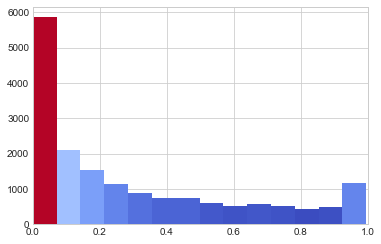

In [7]:
hist(full_history['acousticness'], [0,1])
full_history['acousticness'].describe()

### Danceability

Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

count    17235.000000
mean         0.599629
std          0.170962
min          0.000000
25%          0.483000
50%          0.609000
75%          0.729000
max          0.984000
Name: danceability, dtype: float64

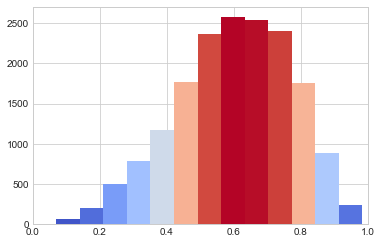

In [8]:
hist(full_history['danceability'], [0,1])
full_history['danceability'].describe()

### Duration

The duration of the track in milliseconds. Convert the duration to floating-point minutes.

count    17235.000000
mean         3.876867
std          1.448328
min          0.528667
25%          3.139500
50%          3.665033
75%          4.348950
max         41.983333
Name: duration, dtype: float64

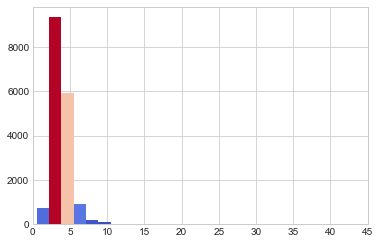

In [9]:
full_history['duration'] = full_history['duration_ms'] / 1000 / 60
hist(full_history['duration'], [0,45], 25)
full_history['duration'].describe()

In [10]:
full_history = full_history.drop('duration_ms', axis=1)

### Energy

Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

count    17235.000000
mean         0.589826
std          0.229063
min          0.000577
25%          0.452000
50%          0.609000
75%          0.762500
max          0.998000
Name: energy, dtype: float64

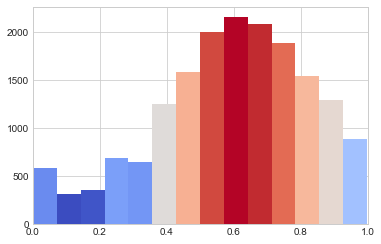

In [11]:
hist(full_history['energy'], [0,1])
full_history['energy'].describe()

### Liveness

Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

count    17235.000000
mean         0.189863
std          0.153152
min          0.017600
25%          0.097200
50%          0.125000
75%          0.233000
max          0.989000
Name: liveness, dtype: float64

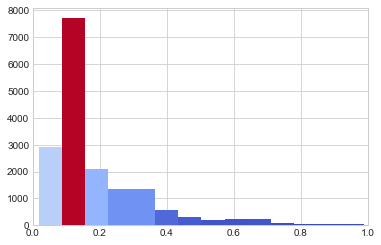

In [12]:
hist(full_history['liveness'], [0,1])
full_history['liveness'].describe()

In [13]:
full_history[full_history['liveness'] > 0.8].drop_duplicates('id')['name'][:15]

10059                                     Look Back
10082                                    Brightfall
10138                                       Feel Me
10320                                   La-Di-Da-Di
10358                                     Champions
10435                                          TEAM
1052                                 Round Whippin'
10658                                    So Special
11101                            Roll One Up, Homie
11376                                 Momma Told Me
11815                               Mushroom Clouds
12279                                   The Dreamer
12350                                      Thriller
12456                        Get Up Offa That Thing
1249     Not Nineteen Forever - Live at Heaton Park
Name: name, dtype: object

Liveness is obviously an inaccurate measurement, thus we cannot use it reliably. We remove it.

In [14]:
full_history = full_history.drop('liveness', axis=1)

### Loudness

The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.

Similar to duration, loudness is heavily skewed, thus we log scale it to bring things back together and reveal more of the underlying structure. Note the transformation of the values too. Since we don't care too much about the actual value of the loudness, only whether it's relatively loud or not, we assume this is acceptable.

count    17235.000000
mean         2.144166
std          0.455249
min         -0.529329
25%          1.855360
50%          2.112393
75%          2.366967
max          3.877990
Name: log_loudness, dtype: float64

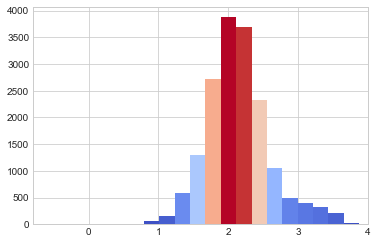

In [15]:
full_history['log_loudness'] = np.log(-1*full_history['loudness']+1)
hist(full_history['log_loudness'], [-0.8,4], 20)
full_history['log_loudness'].describe()

In [16]:
full_history = full_history.drop('loudness', axis=1)

### Popularity

The popularity of the track. The value will be between 0 and 100, with 100 being the most popular.
The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are.

Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity. Note that the popularity value may lag actual popularity by a few days: the value is not updated in real time.

count    17235.000000
mean        53.327415
std         17.579643
min          0.000000
25%         43.000000
50%         55.000000
75%         65.000000
max        100.000000
Name: popularity, dtype: float64

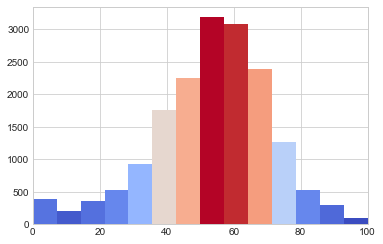

In [17]:
hist(full_history['popularity'], [0, 100])
full_history['popularity'].describe()

### Tempo

The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

count    17235.000000
mean       118.446939
std         30.188259
min          0.000000
25%         94.000000
50%        118.000000
75%        140.000000
max        222.000000
Name: tempo, dtype: float64

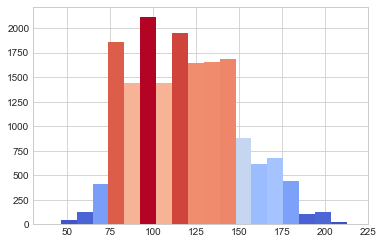

In [18]:
full_history['tempo'] = full_history['tempo'].apply(round)
hist(full_history['tempo'], [30, 225], 24)
full_history['tempo'].describe()

Many songs are misclassified by Spotify, often doubling the real BPM. Presto tempo is said to be above 168, and after looking through many of the resutls of songs above 168 BPM, it is reasonable to correct songs above this threshold. Although it does cut out the top end, it is more representative for  many songs.

In [19]:
full_history['tempo'] = full_history['tempo'].apply(lambda x: x if x < 168 else x/2)

### Valence

A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

count    17235.000000
mean         0.442846
std          0.242088
min          0.000000
25%          0.246000
50%          0.419000
75%          0.624000
max          0.990000
Name: valence, dtype: float64

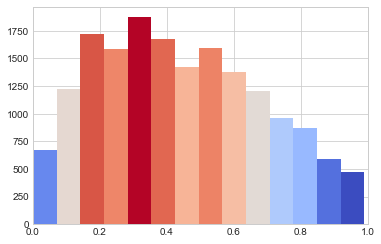

In [20]:
hist(full_history['valence'], [0, 1])
full_history['valence'].describe()

### Release Date

After examining, the release date isn't accurate either. For example, all classical music has release dates of 1960 or later, since this is the release of the album itself, not necessarily the conception of the music (which would have placed a lot of this genre in the 17th-20th centuries).

In [22]:
full_history = full_history.drop('release', axis=1)

ValueError: labels ['release'] not contained in axis

Day and time of the week

In [23]:
def makeWeekday(a):
    '''
    weekday
    '''
    return a.weekday()

def makeDecimalHour(a):
    '''
    decimal hour
    '''
    return a.hour + (a.minute / 60.0)

In [24]:
full_history['weekday'] = full_history['timestamp'].apply(makeWeekday)

full_history['hour_decimal'] = full_history['timestamp'].apply(makeDecimalHour)

In [25]:
full_history.sample(5)

,acousticness,album,artists,danceability,energy,explicit,id,key,mode,name,popularity,speechiness,tempo,time_signature,timestamp,valence,duration,log_loudness,weekday,hour_decimal
3114,0.22700,My Life,"[28j8lBWDdDSHSSt5oPlsX2, 5INjqkS1o8h1imAzPqGZBb]",0.744,0.562,0,2NDZ6i6UfOUSKgFiTQKbnv,0,0,My Life,70,0.0378,110.0,4,2018-05-11 10:09:00-07:00,0.161,4.905850,2.184927,4,10.150000
15484,0.00763,Pop Makossa (Analog Africa No. 23),[0YVakpWhqBiiG3EK8OJisV],0.695,0.836,0,0jOzBuBfj7ppEuD2FoH5lE,11,0,Africa,17,0.0438,131.0,4,2018-05-13 12:07:00-07:00,0.760,7.349017,2.662216,6,12.116667
10639,0.25000,Invincible,"[0PxzGnCYBpSuaI49OR94cA, 5hrtcI0g197yJxmyAU6VYv]",0.310,0.712,0,5pUzE0TnMuLlWGYto3LJSb,7,0,Invincible,50,0.0825,83.0,4,2017-12-18 19:11:00-08:00,0.167,3.613267,1.706746,0,19.183333
15218,0.04780,Choose Your Own Adventure,[4idG41ELGGRKuiHLc3VLc5],0.468,0.636,0,3ItCDZEok1K8DtZi51CWYr,7,1,The Conservation of Energy,41,0.0260,92.0,4,2018-05-13 15:51:00-07:00,0.263,4.224450,2.004583,6,15.850000
1629,0.29600,Little World,[5jLbQGcvxehi2Z6qkUP9Rh],0.733,0.679,0,4PevTpnIWy2D1wIQZY3MmX,7,1,Cool,58,0.2070,94.0,4,2018-01-02 15:28:00-08:00,0.882,2.087267,1.968789,1,15.466667


How much music are we talking about here?

In [26]:
total_hours = full_history['duration'].sum()/(60)
print('Total hours: {:0.3f}'.format(total_hours))

hours_per_day = total_hours/(full_history['timestamp'].max() - full_history['timestamp'].min()).days
print('Hours/day: {:0.1f}'.format(hours_per_day))

avg_song_dur = full_history['duration'].mean()
print('Average songs/day: {:0.0f}'.format(hours_per_day/(avg_song_dur/(60.0))))

print('Total songs listened to: {} (unique songs: {})'.format(len(full_history), len(get_unique())))

Total hours: 1113.630
Hours/day: 5.4
Average songs/day: 83
Total songs listened to: 17235 (unique songs: 8346)


## What kinds of music do I listen to?

First, what types of genres am I listening to?

In [27]:
artists_index = pd.Index(artists['id'])

def addTrackGenres(row):
    inner_gs = []
        
    # for each artist in a track
    for track_artist in row['artists']:
                        
        # if the artist exists, get its index
        i = artists_index.get_loc(track_artist)
        if i > -1:
            cell = artists.iloc[i, 2]
            if cell:
                # collect genres from artists that match the current index
                inner_gs.append(cell)
                
    if inner_gs:
        row['genres'] = np.unique(list(itertools.chain(*inner_gs)))
    else:
        row['genres'] = None
        
    return row

In [28]:
full_history = full_history.apply(addTrackGenres, 1)

In [29]:
genres = []
counts = []
freqs =  []
var1 =   []

for row in full_history.loc[full_history['genres'].notnull(), ['energy', 'genres']].itertuples():
    
    for genre in row.genres:
        
        if genre in genres:
            i = genres.index(genre)
            counts[i] += 1
            var1[i] += row.energy
        else:
            genres.append(genre)
            counts.append(1)
            var1.append(row.energy)

total = sum(counts)
freqs = np.array(counts) / total
var1 = np.array(var1) / np.array(counts)

collective_genres = pd.DataFrame({'freq': freqs, 'count': counts, 'genre': genres, 'var1': var1})

Below is a visualization of my top 25 genres, starting with most listened to. Dark red represents a low energy, dark blue is high energy.

/Users/alex/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


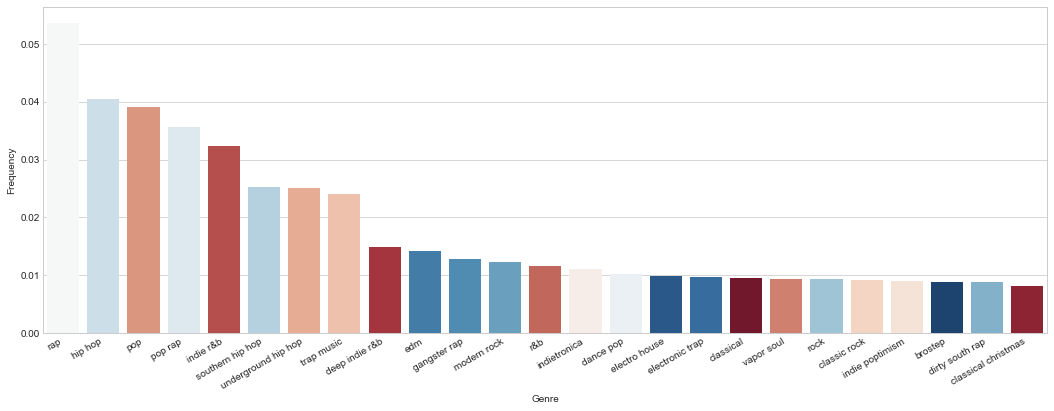

In [30]:
offset = 0
collective_genres = collective_genres.sort_values('freq', ascending=False)

plt.subplots(figsize=(18,6))
g = sns.barplot(x='genre', y='freq', 
                data=collective_genres[offset:offset+25], 
                hue='var1', palette='RdBu', dodge=False)
g.legend_.remove()
plt.xticks(rotation=30, horizontalalignment='right')
plt.xlabel('Genre')
plt.ylabel('Frequency');

What is the overall mood of my music collection like? It is skewed toward a sadder mood, and has a mean valence of 0.4, which isn't particularly happy.

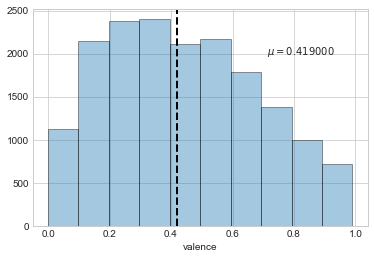

In [31]:
ax = sns.distplot(full_history.valence, bins=10, kde=False, hist_kws={"edgecolor": "k", "linewidth":1})
plt.axvline(full_history.valence.median(), color='k', linestyle='--', linewidth=2);
plt.text(0.8, 0.8, r'$\mu={0:2f}$'.format(full_history.valence.median()), 
         horizontalalignment='center', verticalalignment='center', transform=ax.transAxes);

Who are my most listened to artists?

In [32]:
collective_artists = [artists for artists in full_history.loc[full_history['artists'].notnull(), 'artists']]
    
collective_artists = np.array(list(itertools.chain(*collective_artists)))
unique_artists, artist_counts = np.unique(collective_artists, return_counts=True)

artist_df = pd.DataFrame({'id': unique_artists, 'listens': artist_counts})
artists = pd.merge(artist_df, artists, on='id')

def simplifyGenre(x):
    for genre in collective_genres['genre']:
        if genre in x:
            return genre
        
    return 'other'

artists['simple_genre'] = artists['genres'].apply(simplifyGenre)

Below is a visualization of my most listened to artists. They are counted if they are featured or produce a song as well. The color represents their top-level genre classification.

/Users/alex/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


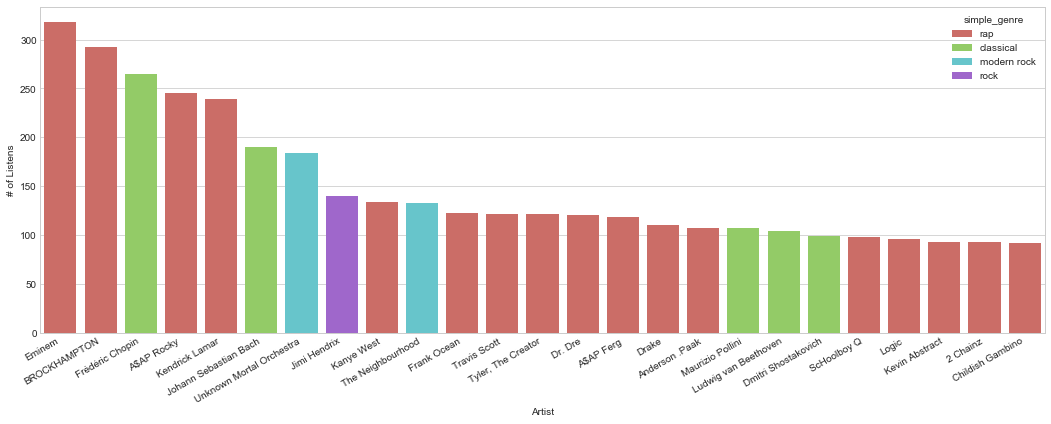

In [33]:
offset = 0
sort_artist_df = artists.sort_values('listens', ascending=False)

plt.subplots(figsize=(18,6))
g = sns.barplot(x='artist', y='listens', data=sort_artist_df[offset:offset+25], hue='simple_genre', dodge=False, palette='hls')
plt.xticks(rotation=30, horizontalalignment='right')
plt.xlabel('Artist');
plt.ylabel('# of Listens');
#plt.savefig('topartists.png')

In [34]:
full_history.to_json('data/history_clean.json')
artists.to_json('data/artists_clean.json')